### Практика
#### Предсказание дохода

In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np
from comet_ml import Experiment
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [2]:
# Create an experiment with your api key
experiment = Experiment(
    api_key="Ra07S6KGK0XAiU2Cl59ZLcuyS",
    project_name="predict-income",
    workspace="dmitriy-b",
    log_code=True
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.com/dmitriy-b/predict-income/6ab45fb1b1454a469ef75a3dd92ae1be



In [3]:
training_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [4]:
# проверка размерности
training_data.shape, test_data.shape

((24420, 13), (8141, 13))

In [5]:
# задаем целевую переменную
target_name = 'income'

# выборки дели на X и y тренировочные и тестовые соответственно
X_train = training_data.drop(columns=[target_name])
y_train = training_data[target_name]

X_test = test_data.drop(columns=[target_name])
y_test = test_data[target_name]


In [6]:
# анализируем целевую переменную на тестовой выборке
print(y_test.value_counts(normalize=True))
print('Вывод: несбалансированная бинарная классификация')

0    0.763297
1    0.236703
Name: income, dtype: float64
Вывод: несбалансированная бинарная классификация


Статистика по числовым данным

In [7]:
X_train.describe().T


,count,mean,std,min,25%,50%,75%,max
age,24420.0,38.598116,13.638458,17.0,28.0,37.0,48.0,90.0
capital-gain,23705.0,1051.724067,7199.945441,0.0,0.0,0.0,0.0,99999.0
capital-loss,23936.0,88.409592,404.466154,0.0,0.0,0.0,0.0,4356.0
hours-per-week,24420.0,40.386568,12.299621,1.0,40.0,40.0,45.0,99.0


COMET WARNING: Failing to save the matplotlib figure


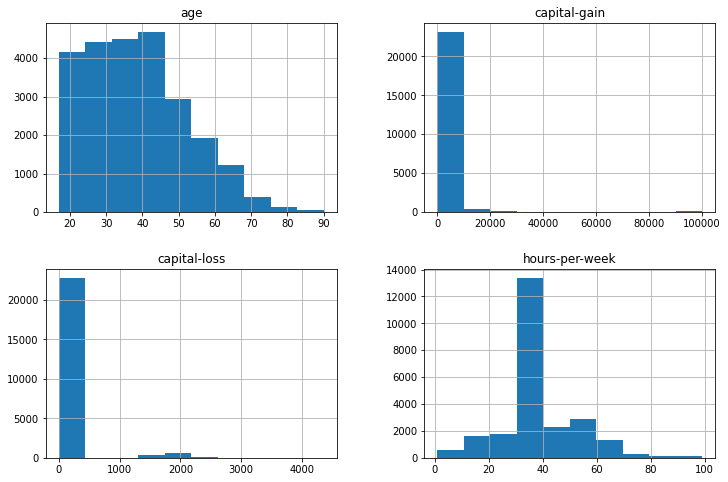

In [8]:
# строим гистограмму
X_train.hist(figsize=(12, 8))
#experiment.log_figure('X_train_numeric_distr', figure=plt) # логируем гистограммы
experiment.log_figure(figure=plt)

1. Числовых признаков 4
2. Возраст 17 - 90 лет
3. Пропуски в capital-loss и capital-gain. По гисстограммам можно наблюдать, что большое количество значений в этих признаках нули.


#### Предобработка данных

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24420 entries, 0 to 24419
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             24420 non-null  int64  
 1   workclass       23223 non-null  object 
 2   education       23443 non-null  object 
 3   marital-status  24420 non-null  object 
 4   occupation      24420 non-null  object 
 5   relationship    24420 non-null  object 
 6   race            24420 non-null  object 
 7   sex             24420 non-null  object 
 8   capital-gain    23705 non-null  float64
 9   capital-loss    23936 non-null  float64
 10  hours-per-week  24420 non-null  int64  
 11  native-country  24420 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 2.2+ MB


- 8 признаков типа object
- 2 признака типа int64
- 2 признака типа float64
- 4 признака содержат пропуски

#### Обработка пропусков
<br>Тренировочную и тестовую выборки необходимо обрабатывать одинаково.
<br>Заполним capital-gain и capital-loss нулями т.к. они фокусируются в основном на нулевых значениях.

In [10]:
X_train['capital-gain'] = X_train['capital-gain'].fillna(0)
X_train['capital-loss'] = X_train['capital-loss'].fillna(0)

X_test['capital-gain'] = X_test['capital-gain'].fillna(0)
X_test['capital-loss'] = X_test['capital-loss'].fillna(0)

Признаки workclass и education категориальные, их заполним модой (частовстречающимися значениями)

In [11]:
X_train['workclass'].mode()

0    Private
Name: workclass, dtype: object

In [12]:
X_train['education'].mode()[0]

'HS-grad'

In [13]:
# моду смотрим на тренирововчной выборке, затем заполняем ею и тестовую выборку
X_train['workclass'] = X_train['workclass'].fillna('Private')
X_train['education'] = X_train['education'].fillna('HS-grad')

X_test['workclass'] = X_test['workclass'].fillna('Private')
X_test['education'] = X_test['education'].fillna('HS-grad')

#### Кодировка категориальных признаков
LabelEncoder и OneHotEncoder

In [14]:
'''# список категориальных признаков
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

# списко некатегориальных признаков
non_categorical_features = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']'''

"# список категориальных признаков\ncategorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']\n\n# списко некатегориальных признаков\nnon_categorical_features = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']"

In [15]:
# создадим списки наименований категориальных и некатегориальных признаков
categorical_features = []
non_categorical_features = []
for i in X_test.columns:
    if X_test[i].dtype == 'O':
        categorical_features.append(i)
    else:
        non_categorical_features.append(i)
        
#display (categorical_features, non_categorical_features)

In [16]:
X_train[categorical_features].head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States
1,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States
2,Private,11th,Married-civ-spouse,Other-service,Husband,Black,Male,United-States
3,Private,Bachelors,Separated,Adm-clerical,Unmarried,White,Male,United-States
4,Private,Bachelors,Divorced,Sales,Not-in-family,White,Female,United-States


#### Используем метод порядкового кодирования LabelEncoder

In [17]:
# создадим копии выборок
X_train_le = X_train.copy()
X_test_le = X_test.copy()

# инициализируем метод кодирования
label_encoder = LabelEncoder()

# с помощью цикла закодируем признаки
for i in categorical_features:
    X_train_le[i] = label_encoder.fit_transform(X_train_le[i])
    X_test_le[i] = label_encoder.fit_transform(X_test_le[i])

In [18]:
X_train_le.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,49,4,11,2,3,0,4,1,0.0,0.0,40,39
1,27,4,11,2,7,0,4,1,0.0,0.0,45,39
2,44,4,1,2,8,0,2,1,0.0,0.0,60,39
3,59,4,9,5,1,4,4,1,0.0,0.0,60,39
4,54,4,9,0,12,1,4,0,0.0,1408.0,38,39


#### Используем метод горячего кодирования OneHotEncoder

In [19]:
# инициализация кодировщика
onehot_encoder = OneHotEncoder()

# Обучаем на тестовой выборке и сразу применяем кодирование к тойже тестовой выборке и запишем массив в новую переменную
X_train_onehot = onehot_encoder.fit_transform(X_train[categorical_features]).toarray()

# Обученную модель строкой ранее применяем к тестовой выборке и записываем массив в новой переменной
X_test_onehot = onehot_encoder.transform(X_test[categorical_features]).toarray()

# получим наименование новых колонок после кодирования и запишем в переменную
columns = onehot_encoder.get_feature_names(categorical_features) # 99 новых признаков

# новые таблицы трансформируем в DataFrame
X_train_onehot = pd.DataFrame(X_train_onehot, columns=columns)
X_test_onehot = pd.DataFrame(X_test_onehot, columns=columns)


c:\Users\dmitr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [20]:
# создаем новый дата-сет, где соединим X_train (т.к. там остались цифровые признаки) и X_train_onehot, так же и с тестовой выборкой
X_train_new = pd.concat([X_train, X_train_onehot], axis=1)
X_test_new = pd.concat([X_test, X_test_onehot], axis=1)

In [21]:
# из новых таблиц удалим исходные категориальные признаки
X_train_new = X_train_new.drop(columns=categorical_features)
X_test_new = X_test_new.drop(columns=categorical_features)


#### Обучение модели

Для классификатора используем логистическую регрессию

In [25]:
# инициализация модели линейной регрессии для таблицы с горячим кодированием OneHotEncoder
linear_model_oh = LogisticRegression()

# инициализация модели линейной регрессии для таблицы с порядковым кодированием LabelEncoder
linear_model = LogisticRegression()

In [ ]:
# Обучение моделей
linear_model_oh.fit(X_train_new, y_train)

linear_model.fit(X_train_le, y_train)

In [24]:
#experiment.end()